In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab
%matplotlib inline
import os
import math
import time
import tensorflow as tf
from datasets import dataset_utils,cifar10
from tensorflow.contrib import slim

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
dropout_keep_prob=0.8
image_size = 32
step=20000
learning_rate=0.0002
train_dir = '/tmp/cifar10/5deep'

In [3]:
cifar10_data_dir='/media/ramdisk/data/cifar10'

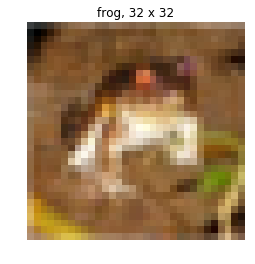

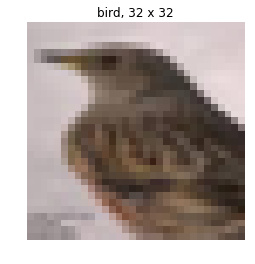

In [4]:
display_step=2

with tf.Graph().as_default(): 
    dataset = cifar10.get_split('train', cifar10_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])

    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(display_step):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()


In [5]:

def cnn_relu(images, num_classes, is_training):
    #https://github.com/agrawalnishant/tensorflow-1/tree/master/tensorflow/contrib/slim 
    ##vgg와  cifarndet을 참조함
    with slim.arg_scope([slim.max_pool2d], stride=2): 

        net = slim.repeat(images,2, slim.conv2d, 64, [5, 5], scope='conv1',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 3, slim.conv2d, 128, [5, 5], scope='conv2',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 5, slim.conv2d, 256, [5, 5], scope='conv3',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 6, slim.conv2d, 512, [5, 5], scope='conv4',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool4')

       
        net = slim.conv2d(net, 1024, [2, 2], padding="VALID", scope='fc6')
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                         scope='dropout6')
        net = slim.conv2d(net, 1024, [1, 1], scope='fc8', activation_fn=None)
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                           scope='dropout7')
        net = slim.conv2d(net, num_classes, [1, 1],
                          activation_fn=None,
                          normalizer_fn=None,
                          scope='fc9')
        
        net = tf.squeeze(net, [1,2],name='fc9/squeezed')
        
        return net

In [6]:
from preprocessing import cifarnet_preprocessing

def load_batch(dataset, batch_size=128, height=image_size, width=image_size, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=128,
        common_queue_min=32)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = cifarnet_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=4,
          capacity=4 * batch_size)
    
    return images, images_raw, labels

In [7]:
%%time
# This might take a few minutes.

print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = cifar10.get_split('train', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
  
    # Create the model:
    logits =cnn_relu(images, num_classes=dataset.num_classes, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    
    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
    
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=step, 
          log_every_n_steps=10,
        save_interval_secs=100,
      save_summaries_secs=100)
  
    print('Finished training. Final batch loss %d' % final_loss)

Will save model to /tmp/cifar10/5deep
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/5deep/model.ckpt
INFO:tensorflow:St

INFO:tensorflow:global step 810: loss = 2.3019 (0.209 sec/step)
INFO:tensorflow:global step 820: loss = 2.3020 (0.233 sec/step)
INFO:tensorflow:global step 830: loss = 2.3033 (0.213 sec/step)
INFO:tensorflow:global step 840: loss = 2.3035 (0.233 sec/step)
INFO:tensorflow:global step 850: loss = 2.3024 (0.232 sec/step)
INFO:tensorflow:global step 860: loss = 2.3030 (0.207 sec/step)
INFO:tensorflow:global step 870: loss = 2.3009 (0.217 sec/step)
INFO:tensorflow:global step 880: loss = 2.3016 (0.228 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/5deep/model.ckpt
INFO:tensorflow:global_step/sec: 4.44999
INFO:tensorflow:Recording summary at step 884.
INFO:tensorflow:global step 890: loss = 2.3024 (0.220 sec/step)
INFO:tensorflow:global step 900: loss = 2.3023 (0.216 sec/step)
INFO:tensorflow:global step 910: loss = 2.3006 (0.225 sec/step)
INFO:tensorflow:global step 920: loss = 2.3056 (0.203 sec/step)
INFO:tensorflow:global step 930: loss = 2.3030 (0.226 sec/step)
INFO:ten

INFO:tensorflow:global step 2000: loss = 2.3063 (0.228 sec/step)
INFO:tensorflow:global step 2010: loss = 2.3030 (0.226 sec/step)
INFO:tensorflow:global step 2020: loss = 2.3022 (0.216 sec/step)
INFO:tensorflow:global step 2030: loss = 2.3019 (0.224 sec/step)
INFO:tensorflow:global step 2040: loss = 2.3027 (0.230 sec/step)
INFO:tensorflow:global step 2050: loss = 2.3038 (0.219 sec/step)
INFO:tensorflow:global step 2060: loss = 2.3031 (0.221 sec/step)
INFO:tensorflow:global step 2070: loss = 2.3004 (0.224 sec/step)
INFO:tensorflow:global step 2080: loss = 2.3018 (0.203 sec/step)
INFO:tensorflow:global step 2090: loss = 2.3038 (0.211 sec/step)
INFO:tensorflow:global step 2100: loss = 2.3029 (0.217 sec/step)
INFO:tensorflow:global step 2110: loss = 2.3025 (0.223 sec/step)
INFO:tensorflow:global step 2120: loss = 2.3021 (0.226 sec/step)
INFO:tensorflow:global step 2130: loss = 2.3018 (0.224 sec/step)
INFO:tensorflow:global step 2140: loss = 2.3022 (0.217 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3190: loss = 2.3019 (0.223 sec/step)
INFO:tensorflow:global step 3200: loss = 2.3029 (0.230 sec/step)
INFO:tensorflow:global step 3210: loss = 2.3032 (0.224 sec/step)
INFO:tensorflow:global step 3220: loss = 2.3012 (0.214 sec/step)
INFO:tensorflow:global step 3230: loss = 2.3029 (0.231 sec/step)
INFO:tensorflow:global step 3240: loss = 2.3047 (0.222 sec/step)
INFO:tensorflow:global step 3250: loss = 2.3023 (0.216 sec/step)
INFO:tensorflow:global step 3260: loss = 2.3057 (0.235 sec/step)
INFO:tensorflow:global step 3270: loss = 2.3028 (0.223 sec/step)
INFO:tensorflow:global step 3280: loss = 2.3030 (0.210 sec/step)
INFO:tensorflow:global step 3290: loss = 2.3026 (0.228 sec/step)
INFO:tensorflow:global step 3300: loss = 2.3028 (0.213 sec/step)
INFO:tensorflow:global step 3310: loss = 2.3018 (0.215 sec/step)
INFO:tensorflow:global step 3320: loss = 2.3014 (0.226 sec/step)
INFO:tensorflow:global step 3330: loss = 2.3041 (0.237 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4410: loss = 2.3034 (0.226 sec/step)
INFO:tensorflow:global step 4420: loss = 2.3007 (0.209 sec/step)
INFO:tensorflow:global step 4430: loss = 2.3059 (0.219 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/5deep/model.ckpt
INFO:tensorflow:global step 4440: loss = 2.3026 (0.259 sec/step)
INFO:tensorflow:Recording summary at step 4440.
INFO:tensorflow:global step 4450: loss = 2.3025 (0.214 sec/step)
INFO:tensorflow:global step 4460: loss = 2.3041 (0.241 sec/step)
INFO:tensorflow:global step 4470: loss = 2.3030 (0.210 sec/step)
INFO:tensorflow:global step 4480: loss = 2.3050 (0.242 sec/step)
INFO:tensorflow:global step 4490: loss = 2.3044 (0.231 sec/step)
INFO:tensorflow:global step 4500: loss = 2.3046 (0.247 sec/step)
INFO:tensorflow:global step 4510: loss = 2.3024 (0.217 sec/step)
INFO:tensorflow:global step 4520: loss = 2.3032 (0.213 sec/step)
INFO:tensorflow:global step 4530: loss = 2.3030 (0.215 sec/step)
INFO:tensorflow:global step 4540: l

INFO:tensorflow:global step 5620: loss = 2.3028 (0.224 sec/step)
INFO:tensorflow:global step 5630: loss = 2.3028 (0.217 sec/step)
INFO:tensorflow:global step 5640: loss = 2.3017 (0.222 sec/step)
INFO:tensorflow:global step 5650: loss = 2.3035 (0.224 sec/step)
INFO:tensorflow:global step 5660: loss = 2.3044 (0.218 sec/step)
INFO:tensorflow:global step 5670: loss = 2.3037 (0.226 sec/step)
INFO:tensorflow:global step 5680: loss = 2.3030 (0.235 sec/step)
INFO:tensorflow:global step 5690: loss = 2.3024 (0.229 sec/step)
INFO:tensorflow:global step 5700: loss = 2.3015 (0.228 sec/step)
INFO:tensorflow:global step 5710: loss = 2.3031 (0.212 sec/step)
INFO:tensorflow:global step 5720: loss = 2.3035 (0.229 sec/step)
INFO:tensorflow:global step 5730: loss = 2.3060 (0.210 sec/step)
INFO:tensorflow:global step 5740: loss = 2.3022 (0.237 sec/step)
INFO:tensorflow:global step 5750: loss = 2.3030 (0.226 sec/step)
INFO:tensorflow:global step 5760: loss = 2.3018 (0.219 sec/step)
INFO:tensorflow:Saving ch

INFO:tensorflow:global step 6830: loss = 2.3031 (0.222 sec/step)
INFO:tensorflow:global step 6840: loss = 2.3027 (0.217 sec/step)
INFO:tensorflow:global step 6850: loss = 2.3025 (0.226 sec/step)
INFO:tensorflow:global step 6860: loss = 2.3027 (0.221 sec/step)
INFO:tensorflow:global step 6870: loss = 2.3039 (0.226 sec/step)
INFO:tensorflow:global step 6880: loss = 2.3036 (0.239 sec/step)
INFO:tensorflow:global step 6890: loss = 2.3033 (0.221 sec/step)
INFO:tensorflow:global step 6900: loss = 2.3036 (0.223 sec/step)
INFO:tensorflow:global step 6910: loss = 2.3030 (0.231 sec/step)
INFO:tensorflow:global step 6920: loss = 2.3029 (0.223 sec/step)
INFO:tensorflow:global step 6930: loss = 2.3043 (0.212 sec/step)
INFO:tensorflow:global step 6940: loss = 2.3024 (0.219 sec/step)
INFO:tensorflow:global step 6950: loss = 2.3034 (0.237 sec/step)
INFO:tensorflow:global step 6960: loss = 2.3032 (0.222 sec/step)
INFO:tensorflow:global step 6970: loss = 2.3030 (0.225 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8040: loss = 2.3028 (0.227 sec/step)
INFO:tensorflow:global step 8050: loss = 2.3020 (0.220 sec/step)
INFO:tensorflow:global step 8060: loss = 2.3023 (0.228 sec/step)
INFO:tensorflow:global step 8070: loss = 2.3026 (0.219 sec/step)
INFO:tensorflow:global step 8080: loss = 2.3040 (0.227 sec/step)
INFO:tensorflow:global step 8090: loss = 2.3036 (0.222 sec/step)
INFO:tensorflow:global step 8100: loss = 2.3031 (0.227 sec/step)
INFO:tensorflow:global step 8110: loss = 2.3019 (0.213 sec/step)
INFO:tensorflow:global step 8120: loss = 2.3030 (0.225 sec/step)
INFO:tensorflow:global step 8130: loss = 2.3030 (0.242 sec/step)
INFO:tensorflow:global step 8140: loss = 2.3031 (0.235 sec/step)
INFO:tensorflow:global step 8150: loss = 2.3035 (0.217 sec/step)
INFO:tensorflow:global step 8160: loss = 2.3044 (0.215 sec/step)
INFO:tensorflow:global step 8170: loss = 2.3028 (0.230 sec/step)
INFO:tensorflow:global step 8180: loss = 2.3013 (0.214 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9270: loss = 2.3033 (0.228 sec/step)
INFO:tensorflow:global step 9280: loss = 2.3027 (0.214 sec/step)
INFO:tensorflow:global step 9290: loss = 2.3032 (0.224 sec/step)
INFO:tensorflow:global step 9300: loss = 2.3030 (0.224 sec/step)
INFO:tensorflow:global step 9310: loss = 2.3025 (0.240 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/5deep/model.ckpt
INFO:tensorflow:global step 9320: loss = 2.3024 (0.263 sec/step)
INFO:tensorflow:Recording summary at step 9320.
INFO:tensorflow:global step 9330: loss = 2.3018 (0.227 sec/step)
INFO:tensorflow:global step 9340: loss = 2.3027 (0.208 sec/step)
INFO:tensorflow:global step 9350: loss = 2.3015 (0.219 sec/step)
INFO:tensorflow:global step 9360: loss = 2.3022 (0.235 sec/step)
INFO:tensorflow:global step 9370: loss = 2.3025 (0.209 sec/step)
INFO:tensorflow:global step 9380: loss = 2.3038 (0.215 sec/step)
INFO:tensorflow:global step 9390: loss = 2.3017 (0.212 sec/step)
INFO:tensorflow:global step 9400: l

INFO:tensorflow:global step 10470: loss = 2.3027 (0.230 sec/step)
INFO:tensorflow:global step 10480: loss = 2.3021 (0.216 sec/step)
INFO:tensorflow:global step 10490: loss = 2.3032 (0.220 sec/step)
INFO:tensorflow:global step 10500: loss = 2.3020 (0.217 sec/step)
INFO:tensorflow:global step 10510: loss = 2.3026 (0.210 sec/step)
INFO:tensorflow:global step 10520: loss = 2.3012 (0.231 sec/step)
INFO:tensorflow:global step 10530: loss = 2.3019 (0.220 sec/step)
INFO:tensorflow:global step 10540: loss = 2.3030 (0.239 sec/step)
INFO:tensorflow:global step 10550: loss = 2.3013 (0.210 sec/step)
INFO:tensorflow:global step 10560: loss = 2.3023 (0.227 sec/step)
INFO:tensorflow:global step 10570: loss = 2.3016 (0.217 sec/step)
INFO:tensorflow:global step 10580: loss = 2.3036 (0.225 sec/step)
INFO:tensorflow:global step 10590: loss = 2.3020 (0.225 sec/step)
INFO:tensorflow:global step 10600: loss = 2.3021 (0.213 sec/step)
INFO:tensorflow:global step 10610: loss = 2.3025 (0.213 sec/step)
INFO:tenso

INFO:tensorflow:global step 11660: loss = 2.3034 (0.237 sec/step)
INFO:tensorflow:global step 11670: loss = 2.3019 (0.228 sec/step)
INFO:tensorflow:global step 11680: loss = 2.3037 (0.223 sec/step)
INFO:tensorflow:global step 11690: loss = 2.3027 (0.228 sec/step)
INFO:tensorflow:global step 11700: loss = 2.3019 (0.225 sec/step)
INFO:tensorflow:global step 11710: loss = 2.3020 (0.225 sec/step)
INFO:tensorflow:global step 11720: loss = 2.3024 (0.216 sec/step)
INFO:tensorflow:global step 11730: loss = 2.3014 (0.229 sec/step)
INFO:tensorflow:global step 11740: loss = 2.3030 (0.208 sec/step)
INFO:tensorflow:global step 11750: loss = 2.3015 (0.213 sec/step)
INFO:tensorflow:global step 11760: loss = 2.3032 (0.204 sec/step)
INFO:tensorflow:global step 11770: loss = 2.3023 (0.217 sec/step)
INFO:tensorflow:global step 11780: loss = 2.3021 (0.215 sec/step)
INFO:tensorflow:global step 11790: loss = 2.3031 (0.251 sec/step)
INFO:tensorflow:global step 11800: loss = 2.3027 (0.235 sec/step)
INFO:tenso

INFO:tensorflow:global step 12870: loss = 2.3020 (0.229 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/5deep/model.ckpt
INFO:tensorflow:Recording summary at step 12879.
INFO:tensorflow:global step 12880: loss = 2.3035 (0.350 sec/step)
INFO:tensorflow:global step 12890: loss = 2.3026 (0.207 sec/step)
INFO:tensorflow:global step 12900: loss = 2.3022 (0.210 sec/step)
INFO:tensorflow:global step 12910: loss = 2.3022 (0.232 sec/step)
INFO:tensorflow:global step 12920: loss = 2.3034 (0.234 sec/step)
INFO:tensorflow:global step 12930: loss = 2.3027 (0.224 sec/step)
INFO:tensorflow:global step 12940: loss = 2.3021 (0.242 sec/step)
INFO:tensorflow:global step 12950: loss = 2.3023 (0.227 sec/step)
INFO:tensorflow:global step 12960: loss = 2.3023 (0.213 sec/step)
INFO:tensorflow:global step 12970: loss = 2.3027 (0.225 sec/step)
INFO:tensorflow:global step 12980: loss = 2.3026 (0.215 sec/step)
INFO:tensorflow:global step 12990: loss = 2.3030 (0.224 sec/step)
INFO:tensorflow:globa

INFO:tensorflow:global step 14060: loss = 2.3024 (0.212 sec/step)
INFO:tensorflow:global step 14070: loss = 2.3025 (0.209 sec/step)
INFO:tensorflow:global step 14080: loss = 2.3031 (0.225 sec/step)
INFO:tensorflow:global step 14090: loss = 2.3035 (0.234 sec/step)
INFO:tensorflow:global step 14100: loss = 2.3023 (0.217 sec/step)
INFO:tensorflow:global step 14110: loss = 2.3024 (0.218 sec/step)
INFO:tensorflow:global step 14120: loss = 2.3037 (0.238 sec/step)
INFO:tensorflow:global step 14130: loss = 2.3026 (0.226 sec/step)
INFO:tensorflow:global step 14140: loss = 2.3029 (0.215 sec/step)
INFO:tensorflow:global step 14150: loss = 2.3029 (0.228 sec/step)
INFO:tensorflow:global step 14160: loss = 2.3026 (0.232 sec/step)
INFO:tensorflow:global step 14170: loss = 2.3035 (0.215 sec/step)
INFO:tensorflow:global step 14180: loss = 2.3025 (0.217 sec/step)
INFO:tensorflow:global step 14190: loss = 2.3023 (0.218 sec/step)
INFO:tensorflow:global step 14200: loss = 2.3020 (0.220 sec/step)
INFO:tenso

INFO:tensorflow:global step 15250: loss = 2.3033 (0.217 sec/step)
INFO:tensorflow:global step 15260: loss = 2.3019 (0.223 sec/step)
INFO:tensorflow:global step 15270: loss = 2.3022 (0.225 sec/step)
INFO:tensorflow:global step 15280: loss = 2.3025 (0.215 sec/step)
INFO:tensorflow:global step 15290: loss = 2.3026 (0.224 sec/step)
INFO:tensorflow:global step 15300: loss = 2.3016 (0.227 sec/step)
INFO:tensorflow:global step 15310: loss = 2.3024 (0.218 sec/step)
INFO:tensorflow:global step 15320: loss = 2.3026 (0.235 sec/step)
INFO:tensorflow:global step 15330: loss = 2.3021 (0.207 sec/step)
INFO:tensorflow:global step 15340: loss = 2.3039 (0.222 sec/step)
INFO:tensorflow:global step 15350: loss = 2.3022 (0.208 sec/step)
INFO:tensorflow:global step 15360: loss = 2.3016 (0.208 sec/step)
INFO:tensorflow:global step 15370: loss = 2.3031 (0.211 sec/step)
INFO:tensorflow:global step 15380: loss = 2.3021 (0.224 sec/step)
INFO:tensorflow:global step 15390: loss = 2.3037 (0.245 sec/step)
INFO:tenso

INFO:tensorflow:global step 16460: loss = 2.3032 (0.216 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/5deep/model.ckpt
INFO:tensorflow:Recording summary at step 16462.
INFO:tensorflow:global step 16470: loss = 2.3023 (0.227 sec/step)
INFO:tensorflow:global step 16480: loss = 2.3028 (0.233 sec/step)
INFO:tensorflow:global step 16490: loss = 2.3029 (0.217 sec/step)
INFO:tensorflow:global step 16500: loss = 2.3025 (0.224 sec/step)
INFO:tensorflow:global step 16510: loss = 2.3031 (0.222 sec/step)
INFO:tensorflow:global step 16520: loss = 2.3025 (0.221 sec/step)
INFO:tensorflow:global step 16530: loss = 2.3025 (0.238 sec/step)
INFO:tensorflow:global step 16540: loss = 2.3028 (0.218 sec/step)
INFO:tensorflow:global step 16550: loss = 2.3021 (0.227 sec/step)
INFO:tensorflow:global step 16560: loss = 2.3025 (0.212 sec/step)
INFO:tensorflow:global step 16570: loss = 2.3027 (0.213 sec/step)
INFO:tensorflow:global step 16580: loss = 2.3024 (0.238 sec/step)
INFO:tensorflow:globa

INFO:tensorflow:global step 17650: loss = 2.3035 (0.230 sec/step)
INFO:tensorflow:global step 17660: loss = 2.3033 (0.213 sec/step)
INFO:tensorflow:global step 17670: loss = 2.3024 (0.219 sec/step)
INFO:tensorflow:global step 17680: loss = 2.3031 (0.214 sec/step)
INFO:tensorflow:global step 17690: loss = 2.3021 (0.209 sec/step)
INFO:tensorflow:global step 17700: loss = 2.3024 (0.233 sec/step)
INFO:tensorflow:global step 17710: loss = 2.3026 (0.220 sec/step)
INFO:tensorflow:global step 17720: loss = 2.3020 (0.216 sec/step)
INFO:tensorflow:global step 17730: loss = 2.3029 (0.232 sec/step)
INFO:tensorflow:global step 17740: loss = 2.3033 (0.217 sec/step)
INFO:tensorflow:global step 17750: loss = 2.3028 (0.221 sec/step)
INFO:tensorflow:global step 17760: loss = 2.3025 (0.222 sec/step)
INFO:tensorflow:global step 17770: loss = 2.3024 (0.222 sec/step)
INFO:tensorflow:global step 17780: loss = 2.3023 (0.214 sec/step)
INFO:tensorflow:global step 17790: loss = 2.3028 (0.230 sec/step)
INFO:tenso

INFO:tensorflow:global step 18840: loss = 2.3023 (0.223 sec/step)
INFO:tensorflow:global step 18850: loss = 2.3026 (0.213 sec/step)
INFO:tensorflow:global step 18860: loss = 2.3031 (0.214 sec/step)
INFO:tensorflow:global step 18870: loss = 2.3025 (0.221 sec/step)
INFO:tensorflow:global step 18880: loss = 2.3028 (0.216 sec/step)
INFO:tensorflow:global step 18890: loss = 2.3023 (0.214 sec/step)
INFO:tensorflow:global step 18900: loss = 2.3032 (0.218 sec/step)
INFO:tensorflow:global step 18910: loss = 2.3024 (0.230 sec/step)
INFO:tensorflow:global step 18920: loss = 2.3034 (0.233 sec/step)
INFO:tensorflow:global step 18930: loss = 2.3029 (0.209 sec/step)
INFO:tensorflow:global step 18940: loss = 2.3030 (0.201 sec/step)
INFO:tensorflow:global step 18950: loss = 2.3025 (0.205 sec/step)
INFO:tensorflow:global step 18960: loss = 2.3034 (0.217 sec/step)
INFO:tensorflow:global step 18970: loss = 2.3016 (0.224 sec/step)
INFO:tensorflow:global step 18980: loss = 2.3031 (0.216 sec/step)
INFO:tenso

In [8]:
%%time

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = cifar10.get_split('test', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = cnn_relu(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/mse':slim.metrics.streaming_mean_squared_error(predictions, labels),
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/TruePositives': slim.metrics.streaming_true_positives(predictions, labels),        
        'eval/TrueNegatives': slim.metrics.streaming_true_negatives(predictions, labels),
        'eval/FalsePositives': slim.metrics.streaming_false_positives(predictions, labels),
        'eval/FalseNegatives': slim.metrics.streaming_false_negatives(predictions, labels),
        'eval/Recall5': slim.metrics.streaming_sparse_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=list(names_to_updates.values()),
        final_op=list(names_to_values.values())
    )

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))


Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the inputs of labels and predictions have been switched.
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-12-04-00:45:29
INFO:tensorflow:Restoring parameters from /tmp/cifar10/5deep/model.ckpt-20000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-04-00:45:30
eval/mse: 12.289062
eval/Accuracy: 0.085938
eval/FalseNegatives: 0.000000
eval/Recall5: 0.546875
eval/TrueNegatives: 0.000000
eval/FalsePositives: 11.000000
eval/TruePositives: 117.000000
CPU times: user 1.82 s, sys: 396 ms, total: 2.21 s
Wall time: 1.28 s


INFO:tensorflow:Restoring parameters from /tmp/cifar10/5deep/model.ckpt-20000


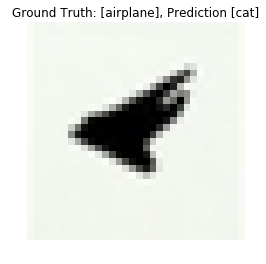

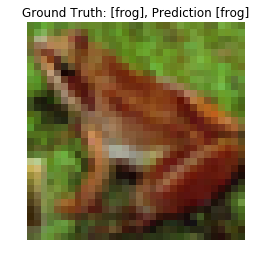

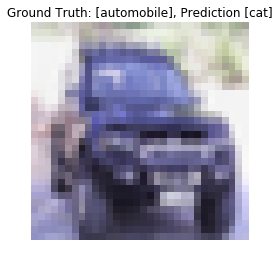

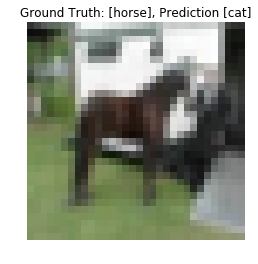

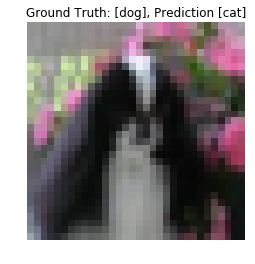

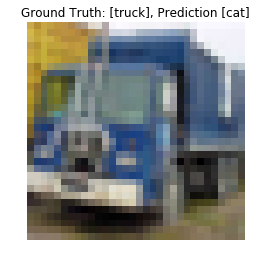

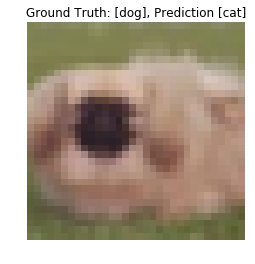

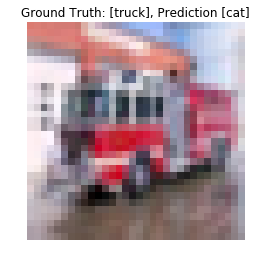

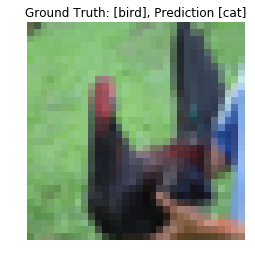

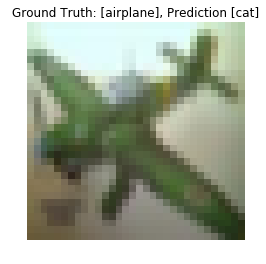

CPU times: user 3.54 s, sys: 1.72 s, total: 5.27 s
Wall time: 1.84 s


In [9]:
%%time
batch_size = 10
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cifar10.get_split('test',cifar10_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    logits = cnn_relu(images, num_classes=dataset.num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()